In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import yfinance as yf
import pendulum

# Fetch stock data from yahoo

In [55]:
# fetch history series
stock = 'IBM' # TSLA, AAPL, GOOG, META, MSFT, AMZN, DIS, IBM etc
# price_history = yf.Ticker(stock).history(period='10y', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
#                                    interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#                                    actions=False)
price_history = yf.Ticker(stock).history(start="2012-11-30", end="2020-12-31", interval='1d', actions=False)
price_history.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-11-30 00:00:00-05:00,124.055839,124.217586,122.600167,122.968941,5163474
2012-12-03 00:00:00-05:00,123.415352,123.764712,121.862626,122.587234,3503682
2012-12-04 00:00:00-05:00,122.736014,123.408859,122.289610,122.509575,4174272
2012-12-05 00:00:00-05:00,122.283128,122.574270,120.943914,122.050224,4395397
2012-12-06 00:00:00-05:00,122.386641,123.040073,121.894947,122.729538,3364564


In [2]:
stocks = ['GOOG', 'AAPL', 'TSLA', 'META', 'MSFT', 'IBM']
prices = list()
for stock in stocks:
    p_1 = yf.Ticker(stock).history(start="2013-01-01", end="2020-12-31", interval='1d', actions=False)
    p_2 = yf.Ticker(stock).history(start="2020-12-31", end="2022-12-31", interval='1d', actions=False)
    prices.append([p_1, p_2])

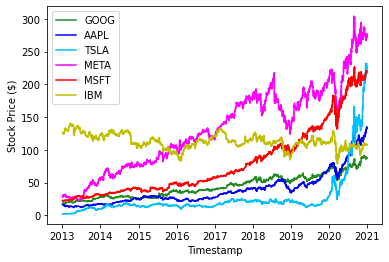

In [3]:
colors = [
        'forestgreen',
        'b',
        'deepskyblue',
        'magenta',
        'r',
        'y'
    ]
for i in range(len(stocks)):
    plt.plot(prices[i][0]['Close'], linestyle='-', color=colors[i], label=stocks[i])
    plt.plot(prices[i][0]['Close'], linestyle='--', color=colors[i])
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Stock Price ($)')
plt.show()

# Train Autoencoder(s)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.20it/s]

Last Loss 5.259034633636475


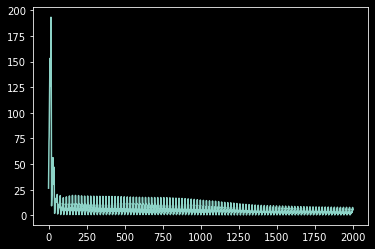

In [208]:
past_days = 32

class FCAE(nn.Module):
    def __init__(self, input_size=past_days):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.dec = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_size)
        )

    def forward(self, x):
        enc = self.enc(x)
        return enc, self.dec(enc)

class FeaturesDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

samples = list()
for r in price_history.rolling(past_days):
    sample = r.values[:, 3]
    if len(sample) < past_days:
        continue
    samples.append(np.array(sample).flatten().tolist())
samples = np.array(samples).astype(np.float32)

fcae = FCAE()
optimizer = optim.Adam(
    fcae.parameters(),
    lr=1e-3
)
# loss_func = nn.MSELoss()
loss_func = nn.HuberLoss()

datasetf = FeaturesDataset(samples)
dataloaderf = DataLoader(datasetf, batch_size=128, shuffle=False)

losses = list()
for epo in tqdm(range(100)):
    for sample in dataloaderf:
        enc, out = fcae(sample)
        loss = loss_func(out, sample)
        
        fcae.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().item())

print('Last Loss', losses[-1])
plt.plot(losses)
plt.show()

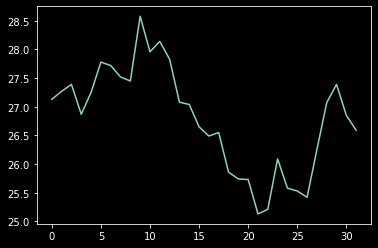

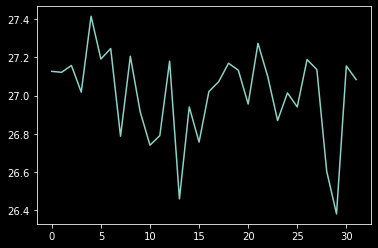

In [154]:
sample = torch.Tensor(samples[np.random.choice(np.arange(len(samples)), 1)])
plt.style.use('dark_background')
plt.plot(sample[0])
plt.show()

with torch.no_grad():
    enc, out = fcae(sample)
    plt.style.use('dark_background')
    plt.plot(out.squeeze().detach().numpy())
    plt.show()

In [155]:
features = list()
for r in price_history.rolling(past_days):
    if len(r) < past_days:
        features.append([np.nan for i in range(32)])
        continue
    with torch.no_grad():
        enc, out = fcae(torch.Tensor([r.values[:, 3]]))
        features.append(enc.squeeze().numpy().tolist())
features = np.array(features)

for i in range(32):
    price_history[i] = features[:, i]
price_history.head(40)

,Open,High,Low,Close,Volume,0,1,2,3,4,...,22,23,24,25,26,27,28,29,30,31
Date,,,,,,,,,,,,,,,,,,,,,
2012-12-03 00:00:00-05:00,28.000000,28.879999,26.980000,27.040001,123526100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-04 00:00:00-05:00,27.059999,27.760000,26.680000,27.459999,72869200,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-05 00:00:00-05:00,27.750000,27.900000,27.260000,27.709999,58976300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-06 00:00:00-05:00,27.680000,27.750000,26.820000,26.969999,46001500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-07 00:00:00-05:00,27.070000,27.780001,26.840000,27.490000,51751900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-10 00:00:00-05:00,27.170000,28.170000,27.100000,27.840000,50608500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-11 00:00:00-05:00,28.070000,28.240000,27.660000,27.980000,77099100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-12 00:00:00-05:00,28.000000,28.139999,27.370001,27.580000,46704200,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-13 00:00:00-05:00,27.590000,28.750000,27.430000,28.240000,81051600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Calculate Market Index

In [56]:
# Moving Average Convergence Divergence (MACD)
k = price_history['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
d = price_history['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
macd = k - d
price_history['macd'] = price_history.index.map(macd)

# Relative Strength Index (RSI)
window_length = 14
diff = price_history['Close'].diff(1)
gain = diff.clip(lower=0).round(2)
loss = diff.clip(upper=0).abs().round(2)
price_history['avg_gain'] = gain.rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
price_history['avg_loss'] = loss.rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
for i, row in enumerate(price_history['avg_gain'].iloc[window_length+1:]):
    price_history['avg_gain'].iloc[i + window_length + 1] = (price_history['avg_gain'].iloc[i + window_length] * (window_length - 1) + gain.iloc[i + window_length + 1]) / window_length
# Average Losses
for i, row in enumerate(price_history['avg_loss'].iloc[window_length+1:]):
    price_history['avg_loss'].iloc[i + window_length + 1] = (price_history['avg_loss'].iloc[i + window_length] * (window_length - 1) + loss.iloc[i + window_length + 1]) / window_length
rs = price_history['avg_gain'] / price_history['avg_loss']
price_history['rsi'] = 100 - (100 / (1.0 + rs))
price_history = price_history.drop('avg_gain', axis=1)
price_history = price_history.drop('avg_loss', axis=1)

# Commodity Channel Index (CCI)
tp = (price_history['High'] + price_history['Low'] + price_history['Close']) / 3
price_history['sma'] = tp.rolling(20).mean()
price_history['adv'] = tp.rolling(20).apply(lambda x: pd.Series(x).mad())
price_history['cci'] = (tp - price_history['sma']) / (0.015 * price_history['adv'])
price_history = price_history.drop('sma', axis=1)
price_history = price_history.drop('adv', axis=1)

# Average Directional Index (ADX)
plus_dm = price_history['High'].diff()
minus_dm = price_history['Low'].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

tr1 = pd.DataFrame(price_history['High'] - price_history['Low'])
tr2 = pd.DataFrame(abs(price_history['High'] - price_history['Close'].shift(1)))
tr3 = pd.DataFrame(abs(price_history['Low'] - price_history['Close'].shift(1)))
frames = [tr1, tr2, tr3]
tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
atr = tr.rolling(14).mean()

plus_di = 100 * (plus_dm.ewm(alpha = 1/14).mean() / atr)
minus_di = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / atr))
dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
adx_smooth = adx.ewm(alpha = 1/14).mean()
price_history['adx'] = adx_smooth

# verbose
price_history = price_history.dropna()
price_history.head(30)

/var/folders/ct/wb53mwvj2gj6k_qjfn3gqzdw0000gn/T/ipykernel_313/1448064029.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_history['avg_gain'].iloc[i + window_length + 1] = (price_history['avg_gain'].iloc[i + window_length] * (window_length - 1) + gain.iloc[i + window_length + 1]) / window_length
/var/folders/ct/wb53mwvj2gj6k_qjfn3gqzdw0000gn/T/ipykernel_313/1448064029.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_history['avg_loss'].iloc[i + window_length + 1] = (price_history['avg_loss'].iloc[i + window_length] * (window_length - 1) + loss.iloc[i + window_length + 1]) / window_length


,Open,High,Low,Close,Volume,macd,rsi,cci,adx
Date,,,,,,,,,
2013-01-08 00:00:00-05:00,124.812747,125.058599,123.958753,124.780396,3166137,0.410518,52.834314,-36.722376,12.874041
2013-01-09 00:00:00-05:00,125.175074,125.181549,123.991132,124.424599,3359752,0.331563,51.113174,-42.308447,12.479009
2013-01-10 00:00:00-05:00,124.638128,124.838680,123.751782,124.786926,3774073,0.294828,52.770095,-44.899472,11.996419
2013-01-11 00:00:00-05:00,125.608562,126.158475,124.799848,125.802650,4058898,0.343714,57.196690,55.354643,11.829869
2013-01-14 00:00:00-05:00,124.748055,125.045662,124.055798,124.618660,4364121,0.283649,51.216326,-36.778728,11.240095
2013-01-15 00:00:00-05:00,123.771117,124.689814,123.175914,124.541016,4364017,0.227163,50.828305,-74.970468,10.462853
2013-01-16 00:00:00-05:00,124.217541,124.980955,123.797014,124.599243,3099193,0.184964,51.127365,-42.788938,10.617629
2013-01-17 00:00:00-05:00,125.414458,125.809108,125.019807,125.285072,4060154,0.204504,54.550725,43.858527,10.373532
2013-01-18 00:00:00-05:00,125.530907,126.158461,125.382108,125.815575,4769342,0.259802,57.039944,90.955634,9.596464


# Split the series into Train, Validation, and Test
(Maybe just Train and Test?)

length 2010


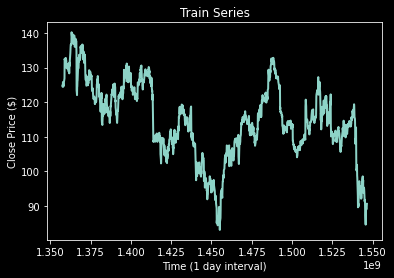

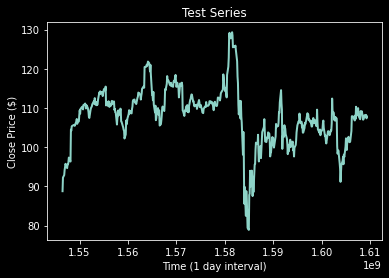

In [57]:
# time_series = list(price_history['Close'])
time_series = price_history
print('length', len(time_series))
dt_list = [pendulum.parse(str(dt)).float_timestamp for dt in list(price_history.index)]

# split into train, val, test
train_portion = 0.75 # 0.8 for 10 years, 0.75 for 8 years
train_ind = int(len(time_series) * train_portion)
# val_ind = train_ind + int(len(time_series) * 0.25)

train_series = time_series[:train_ind]
# val_series = time_series[train_ind:val_ind]
test_series = time_series[train_ind:]

time_int = [
    (0, train_ind), 
#     (train_ind, val_ind), 
    (train_ind, len(time_series))
]
titles = [
    'Train Series', 
#     'Validation Series', 
    'Test Series'
]

# plot
i=0
for series in [train_series, test_series]:
    plt.style.use('dark_background')
    dt_list_c = dt_list[time_int[i][0]:time_int[i][1]]
    plt.plot(dt_list_c, series['Close'], linewidth=2)
    plt.title(titles[i])
    plt.xlabel('Time (1 day interval)')
    plt.ylabel('Close Price ($)')
    i += 1
    plt.show()

# Markov Decision Process (MDP) environment declared here

In [58]:
# Risk/Investment Management
balance_init = 1000 # initial balance in hand
k = 5 # max number of shares
min_balance = -100 # tolerance balance

# action
A = [a for a in range(-k, k+1, 1)]

# transition
def get_features(s, new_record):
    return list(new_record[5:])

def update_state(s, a, new_record):
    # s: (price, balance, shares)
    price, balance, shares = s[0], s[1], s[2]
    # a: (0 is hold, -k is sell, +k is buying)
    
    # Constraints
    # if is sell, check if there are enough number of shares
    if a < 0:
        if shares <= abs(a):
            a = -shares
    elif a > 0: # if buying, check if there are enough balance
        if balance - (a * price) < min_balance:
            possible_balance = np.array([balance - (a_ * price) for a_ in range(a)]) >= min_balance
            a = np.argmax(possible_balance)
    new_shares = shares + a
    new_balance = balance - (a * price)
    
    # apply fee (approx 0.1%)
    new_balance -= (a * price) * 1e-3
    
    # update state
    features = get_features(s, new_record)
    return [new_record['Close'], new_balance, new_shares] + features

# reward
def reward(s, s_next):
    return (s[1] + s[0]*s[2]) - (s_next[1] + s_next[0]*s_next[2])

# interact
def simulate(series, state_init, pi, greedy, eps=0.2):
    Rs = list()
    actions = list()
    states = [state_init]
    for index, row in series.iterrows():
        a = pi(states[-1], greedy=greedy, eps=eps)
        actions.append(a)
        states.append(update_state(states[-1], a, row))
        Rs.append(reward(states[-2], states[-1]))
    return states, Rs, actions

def interact_test(pi, series_name='test', verbose=True):
    if series_name == 'test':
        series = test_series
        prev_series = train_series
        prev_ind = -1
    elif series_name == 'train':
        series = train_series[1:]
        prev_series = train_series
        prev_ind = 0

    state_init = [prev_series['Close'][prev_ind], balance_init, 0] + list(prev_series.iloc[prev_ind][5:]) # price, balance, shares, Index

    # start a trajectory
    states, rewards, actions = simulate(series, state_init, pi, True)

    # verbose
    portforlio = np.array([s[1] + s[0]*s[2] for s in states])
    if verbose:
        print("Profit at The End of Trajactory:", portforlio[-1] - balance_init)

        plt.style.use('dark_background')
        plt.plot(series['Close'])
        plt.title("Price")
        plt.xlabel("Time (1 day inter val)")
        plt.ylabel("Price ($)")
        plt.show()

        plt.style.use('dark_background')
        plt.plot([s[2] for s in states])
        plt.title("Number of Shares")
        plt.xlabel("Time (1 day interval)")
        plt.ylabel("Num shares")
        plt.show()

        plt.style.use('dark_background')
        plt.plot(portforlio)
        plt.title("Portfolio ($)")
        plt.xlabel("Time (1 day inter val)")
        plt.ylabel("Portfolio ($)")
        plt.show()

        plt.style.use('dark_background')
        plt.plot(portforlio - balance_init)
        plt.title("Trading Profit")
        plt.xlabel("Time (1 day interval)")
        plt.ylabel("Profit ($)")
        plt.show()
    
    return portforlio[-1] - balance_init

# Random Action

In [41]:
# policy
def pi_random(s, greedy=False, eps=0.2):
    return np.random.choice(A) # random policy (uniform distributed)

profits = list()
for rep in tqdm(range(20)):
    profits.append(interact_test(pi_random, series_name='test', verbose=False))
print("Avg Profit", np.mean(profits))
print('STD Profit', np.std(profits))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.07it/s]

Avg Profit 194.74989598388672
STD Profit 138.23589682494264


Profit at The End of Trajactory: 1600.2690819549562


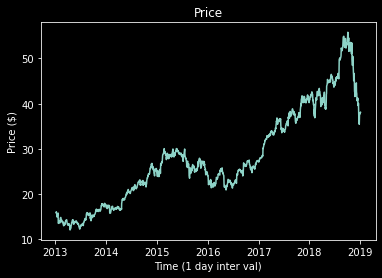

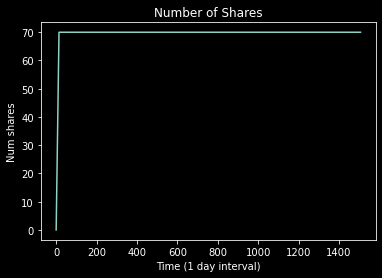

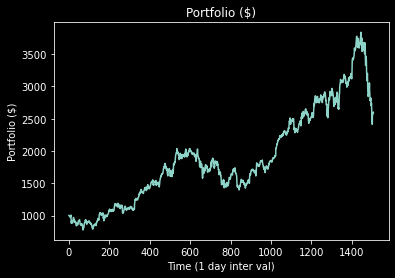

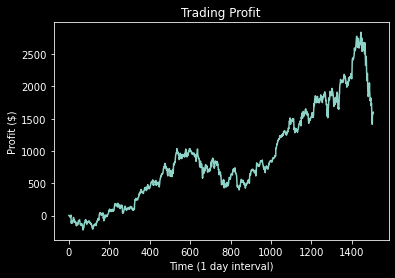

Profit at The End of Trajactory: 2876.6713877105713


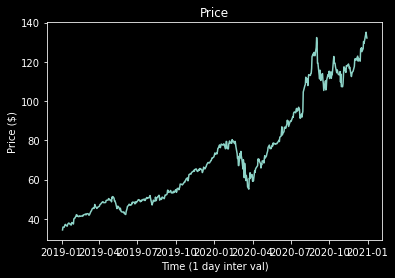

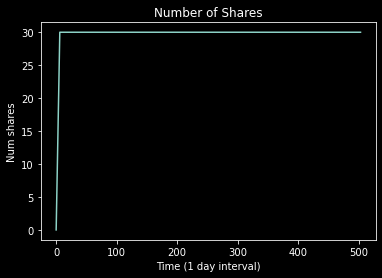

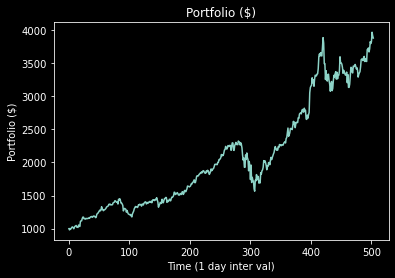

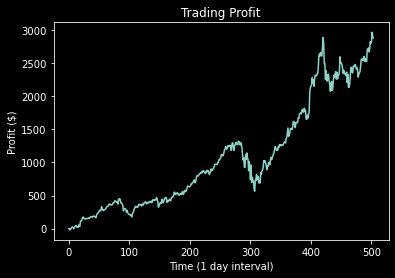

In [21]:
# policy
def pi_hold(s, greedy=False, eps=0.2):
    return A[-1] # Buy at very beginning, hold till the end
final_profit = interact_test(pi_hold, series_name='train', verbose=True)
final_profit = interact_test(pi_hold, series_name='test', verbose=True)

# Deep Q-Learning

In [59]:
class Qsa(nn.Module):
    def __init__(self, input_size=7, num_classes=len(A)):
        super().__init__()
        self.fc_liner = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc_liner(x)

class StatesDataset(Dataset):
    def __init__(self, states, rewards, actions):
        self.states = torch.Tensor(states[:-1]).float()
        self.states_next = torch.Tensor(states[1:]).float()
        self.rewards = torch.Tensor(rewards).float()
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return {
            'states': self.states[idx],
            'states_next': self.states_next[idx],
            'rewards': self.rewards[idx],
            'actions': self.actions[idx]
        }

def deep_q_learning(qsa, 
                    series, 
                    state_init, 
                    pi, 
                    optimizer,
                    loss_func,
                    epochs=10,
                    episode=100, 
                    gamma=0.9,
                    lr=0.7,
                    eps=0.5,
                    min_eps=0.05,
                    decay=0.9,
                    greedy=False,
                    verbose=True,
                    sarsa=False
                   ):
    losses = list()
    learning_curve = list()
    # loop for each episode
    for epi in tqdm(range(episode)):
        # generate a trajectory
        eps *= decay
        states, rewards, actions = simulate(series, state_init, pi, greedy, eps=max(min_eps, eps))
        
        # form dataset and data loader
        dataset = StatesDataset(states, rewards, actions)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
        
        # fit the deep NN
        for epo in range(epochs):
            for data_pack in dataloader:
                input_tensor = data_pack['states']
                out = qsa(input_tensor)
                output_tensor = out[[i for i in range(len(data_pack['rewards']))], [a+k for a in data_pack['actions']]]

                with torch.no_grad():
                    max_qsa_out = qsa(data_pack['states_next'])
                    if not sarsa:
                        max_qsa = max_qsa_out[[i for i in range(len(data_pack['rewards']))], max_qsa_out.argmax(dim=1)]
                        max_qsa = torch.Tensor(data_pack['rewards']).float() + (gamma * max_qsa)
                    else:
                        max_qsa = max_qsa_out[[i for i in range(len(data_pack['rewards']))], [a+k for a in data_pack['actions'][1:]] + [0]]
                    target_tensor = (1 - lr) * output_tensor + lr * max_qsa

                # update weights
                loss = loss_func(output_tensor, target_tensor)
                qsa.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().item())
                
        learning_curve.append(interact_test(pi, series_name='test', verbose=False))
        
    # verbose
    if verbose:
        print("Last loss", losses[-1])
        plt.plot(losses)
        plt.xlabel('Iterations (Not Epochs)')
        plt.ylabel('Loss')
        plt.savefig('loss.pdf')
        plt.show()
    return learning_curve

In [60]:
def train_deep_q(verbose=False):
    qsa = Qsa(input_size=7, num_classes=len(A))
    state_init = [train_series['Close'][0], balance_init, 0] + list(train_series.iloc[0][5:])
    series = train_series[1:]

    optimizer = optim.Adam(
        qsa.parameters(),
        lr=1e-5, # 1e-4
    #     weight_decay=1e-6
    )
#     loss_func = nn.MSELoss()
    loss_func = nn.HuberLoss()

    def pi_deep(s, eps=0.2, greedy=False):
        with torch.no_grad():
            out_qsa = qsa(torch.Tensor(s).float()).squeeze()
            action = out_qsa.argmax().item() - k

            if not greedy:
                r = np.random.rand()
                # if it is on the less side, the explore other actions
                if r > 1 - eps + (eps / len(A)):
                    a_ = np.random.choice(A)
                    while a_ == action:
                        a_ = np.random.choice(A)
                    action = a_
        return action

    learning_curve = deep_q_learning(qsa, 
                                     series, 
                                     state_init, 
                                     pi_deep, 
                                     optimizer,
                                     loss_func,
                                     epochs=10, # number of epochs for training NN in each episode 10
                                     episode=30, # 30
                                     gamma=0.6, # discount coefficient 0.618
                                     lr=0.7, # learning rate for update q function
                                     eps=0.8, # eps greedy policy
                                     min_eps=0.2, # 0.2
                                     decay=0.9, # 0.9
                                     greedy=False,
                                     verbose=verbose
                                    )
    return pi_deep, qsa, learning_curve

100%|██████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.46it/s]

Last loss 13.128291130065918


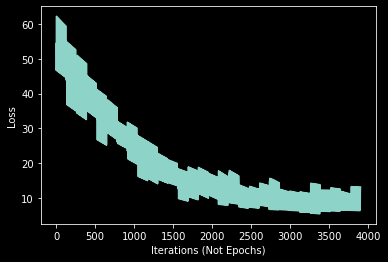

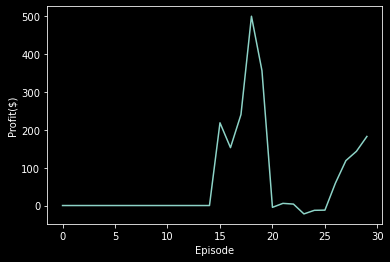

In [15]:
pi_deep, qsa, learning_curve = train_deep_q(verbose=True)
# final_profit = interact_test(pi_deep, series_name='test', verbose=True)
plt.plot(learning_curve)
plt.xlabel("Episode")
plt.ylabel("Profit($)")
plt.savefig('learning_curve.pdf')
plt.show()

Profit at The End of Trajactory: 271.6630179843876


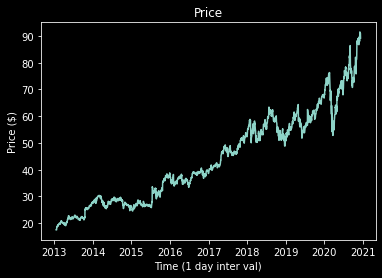

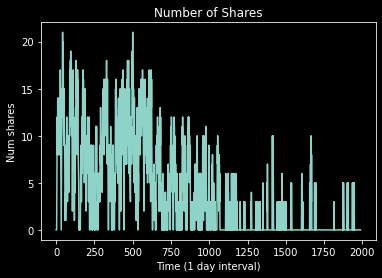

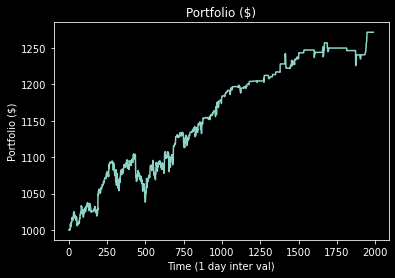

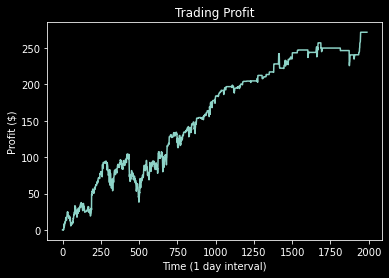

In [110]:
final_profit = interact_test(pi_deep, series_name='train', verbose=True)

100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]


0 Final Profit 78.92235700225842


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]


1 Final Profit 0.0


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.54it/s]


2 Final Profit -57.29175256347639


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]


3 Final Profit -98.53142449188226


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]


4 Final Profit -37.35903563690147


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.61it/s]


5 Final Profit 88.79850456237796


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]


6 Final Profit 0.0


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]


7 Final Profit 148.78330278778094


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]


8 Final Profit 180.66747315216094


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]


9 Final Profit 104.1713907775877


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]


10 Final Profit 2.1719409713746245


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]


11 Final Profit 360.6704720001219


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.61it/s]


12 Final Profit -1.482743469238244


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.57it/s]


13 Final Profit 153.63509645080535


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]


14 Final Profit 51.13338750457751


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]


15 Final Profit -20.199114456176744


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.57it/s]


16 Final Profit 119.75836568450882


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]


17 Final Profit 191.86715346527035


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]


18 Final Profit 67.23832135772682


100%|██████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]

19 Final Profit 176.91368234253014
Avg profit 75.49336887207032
STD profit 105.79113785287217


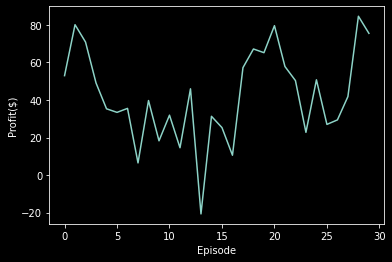

In [61]:
profits = list()
curves = list()
for i in range(20):
    pi_deep, qsa, learning_curve = train_deep_q(verbose=False)
    profits.append(interact_test(pi_deep, series_name='test', verbose=False))
    curves.append(learning_curve)
    print(i, 'Final Profit', profits[-1])
print('Avg profit', np.mean(profits))
print('STD profit', np.std(profits))

plt.plot(np.mean(curves, axis=0))
plt.xlabel("Episode")
plt.ylabel("Profit($)")
plt.savefig('learning_curve.pdf')
plt.show()

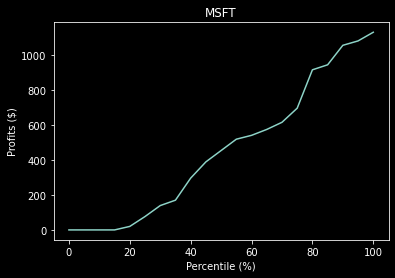

In [29]:
plt.plot([i for i in range(0, 101, 5)], [np.percentile(profits, i) for i in range(0, 101, 5)])
plt.title(stock)
plt.xlabel('Percentile (%)')
plt.ylabel("Profits ($)")
plt.savefig('figures/{}_percentile.pdf'.format(stock))

In [51]:
test_series.head()

,Open,High,Low,Close,Volume,macd,rsi,cci,adx
Date,,,,,,,,,
2020-12-10 00:00:00-05:00,208.060087,209.347135,206.674785,206.831985,26733300,0.075140,44.658190,-109.506059,6.347494
2020-12-11 00:00:00-05:00,206.370230,209.582948,205.446695,209.523987,30979400,0.049185,49.720073,-74.271873,6.359036
2020-12-14 00:00:00-05:00,209.366774,212.422292,209.150627,210.447495,28798400,0.101960,51.358714,42.493756,6.584161
2020-12-15 00:00:00-05:00,211.400528,211.646148,208.521864,210.378754,27000600,0.136663,51.221929,25.657827,6.283985
2020-12-16 00:00:00-05:00,210.987868,216.253968,210.958395,215.438507,35023300,0.565921,59.598410,198.635202,5.934375


In [52]:
test_series.tail()

,Open,High,Low,Close,Volume,macd,rsi,cci,adx
Date,,,,,,,,,
2022-11-28 00:00:00-05:00,246.080002,246.649994,240.800003,241.759995,24778200,2.577413,52.732153,56.181868,17.404106
2022-11-29 00:00:00-05:00,241.399994,242.789993,238.210007,240.330002,17956300,2.287219,51.294913,33.340527,16.407776
2022-11-30 00:00:00-05:00,240.570007,255.330002,239.860001,255.139999,47594200,3.215218,62.649153,99.662427,15.485786
2022-12-01 00:00:00-05:00,253.869995,256.119995,250.919998,254.690002,26024100,3.869745,62.174866,126.019090,15.864535
2022-12-02 00:00:00-05:00,249.820007,252.800003,249.750000,251.285004,6927977,4.066828,58.567163,110.414771,16.280440
